In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import numpy as np

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillageTomato',
    image_size=(256,256),
    batch_size=32,
)

Found 16011 files belonging to 10 classes.


In [3]:
dataset.class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [4]:
class_names = dataset.class_names

In [5]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

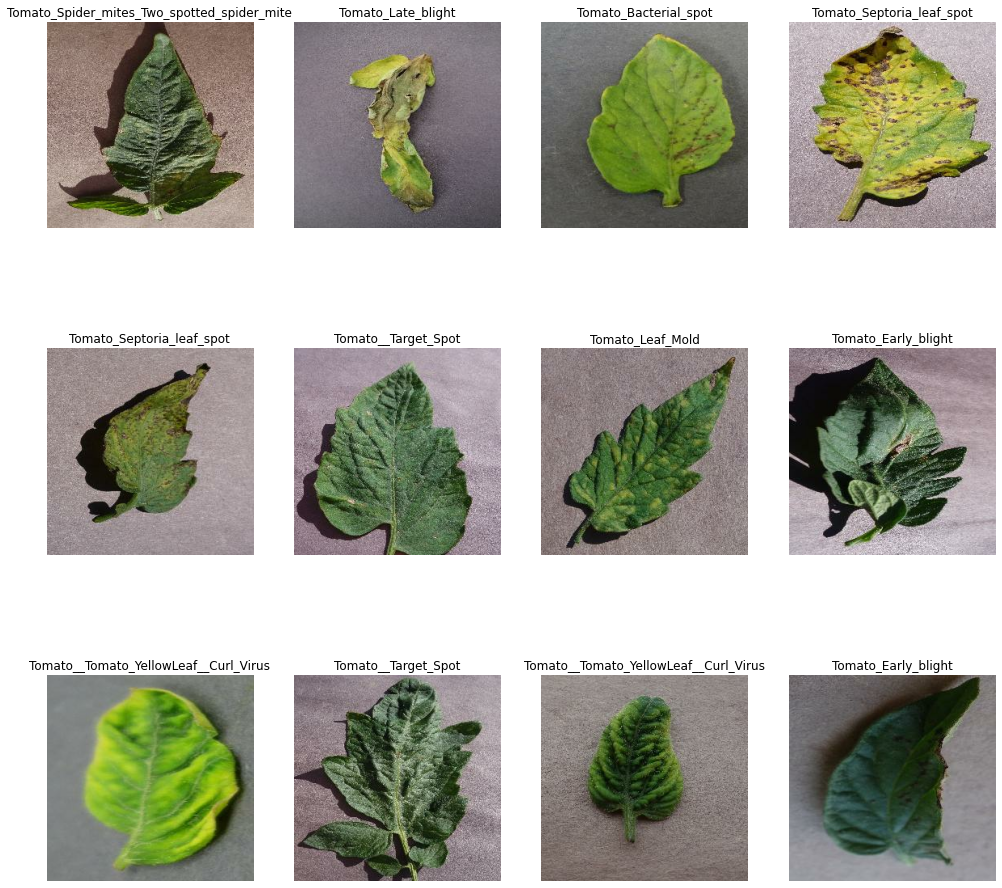

In [6]:
plt.figure(figsize=(17, 17))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

501

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

400

In [11]:
len(val_ds)

50

In [12]:
len(test_ds)

51

In [13]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Resize and Rescale, data augmentation can be done using Imagedatageneratore which is easy and done in one step.

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
input_shape = (32, 256, 256, 3)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [19]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    )

In [21]:
history = model.fit(train_ds,
                   batch_size=32,
                   validation_data=val_ds,
                   epochs=25,
                   verbose=1)

Epoch 1/25
400/400 [==============================] - 357s 889ms/step - loss: 1.5899 - accuracy: 0.4266 - val_loss: 2.9241 - val_accuracy: 0.3438
Epoch 2/25
400/400 [==============================] - 343s 857ms/step - loss: 0.9002 - accuracy: 0.6775 - val_loss: 1.5837 - val_accuracy: 0.5694
Epoch 3/25
400/400 [==============================] - 344s 859ms/step - loss: 0.6340 - accuracy: 0.7749 - val_loss: 1.4290 - val_accuracy: 0.6463
Epoch 4/25
400/400 [==============================] - 333s 832ms/step - loss: 0.5159 - accuracy: 0.8201 - val_loss: 0.8661 - val_accuracy: 0.7281
Epoch 5/25
400/400 [==============================] - 332s 829ms/step - loss: 0.4316 - accuracy: 0.8454 - val_loss: 1.1128 - val_accuracy: 0.7006
Epoch 6/25
400/400 [==============================] - 331s 826ms/step - loss: 0.4068 - accuracy: 0.8564 - val_loss: 1.0150 - val_accuracy: 0.7194
Epoch 7/25
400/400 [==============================] - 331s 826ms/step - loss: 0.3481 - accuracy: 0.8771 - val_loss: 0.8580 -

In [22]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 22s 289ms/step - loss: 0.3494 - accuracy: 0.9193


first image to predict
actual label: Tomato_Spider_mites_Two_spotted_spider_mite
1/1 [==============================] - 0s 263ms/step
predicted label: Tomato_Spider_mites_Two_spotted_spider_mite


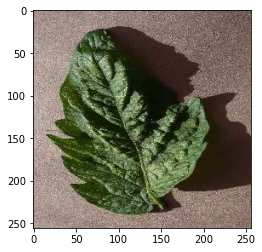

In [33]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])